# Welcome to the calcium imaging data analysis workshop

As you remember, in the  <a href="..\..\BOOTCAMP\Level 3 - Data Science\3c_datasets.ipynb">Bootcamp</a> we learned how to plot and explore the 2p microscope recording of one neuron. 

[Note: If you did not complete bootcamp 3c, do that before starting this workshop.]

Now it's time to take that knowledge to the next level, and learn how to make sense of this data! 

We will be plotting the mean responses, parsed by trial type

In [2]:
#import and load the right library
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat

In [3]:
# load the first neuron
mat = loadmat("calcium_traces_data_non_compressed/0406_20180620_8_timeseries.mat")

#see variables in the file
print(mat.keys())

dict_keys(['__header__', '__version__', '__globals__', 'licks', 'reward', 'punish', 'meanF', 'dff', 'cues', 'go', 'nogo'])


In [4]:
# first, let's store dff in a variable
dff = mat['dff'].flatten()

In this case, we are interested in `cues`.

In [5]:
# let's check again what 'cues' looks like
cues = mat['cues'].flatten()
print(type(cues), cues.shape)

<class 'numpy.ndarray'> (9635,)


In [6]:
# now let's do the same with rewards, punishments, go and nogo cues
reward = mat['reward'].flatten()

punish =mat['punish'].flatten()

go= mat['go'].flatten()

nogo= mat['nogo'].flatten()


In [7]:
#step 1: extract the time points where the cue == 1, and store them as lists
stimtimes = list(np.where(cues ==1)[0])

In [8]:
# get the number of trials 
numtrials = len(stimtimes)

# get the duration of the trial.  The trial duration is the time between one stimulus and the other. 
#think about it, you have a list of time points where the cues happen. How can you get the amount of time between one cue and the next? 
trial_duration = stimtimes[1] - stimtimes[0]  # assumes constant duration

baseline = 2
post_stim_period = trial_duration - baseline - 1

As a recap, we have 2 types of stimuli and 2 types of responses per stimulus.

- Stimuli: Go and NoGo
  - Responses Go: Hit, Miss
  - Responses NoGo: False Alarm, Correct Rejection

At this point, we don't know what our neuron's role is, if it's encoding the sensory stimulus, reward prediction, licking, or if it is involved at all. 

To figure out what our neuron does, first we sort the neuron activity into different "response" containers (Hit, Miss, FA, CR) that are time-locked to the onset of the stimulus. 


In [9]:
# Step 2: Allocate Containers
# the neuron response will be sorted into 4 different responses

# hit:  Go + reward (mouse licks because it should)
hit_waves = [] #create a tuple of the s

#miss: Go + no reward (mouse does not lick but it should)
miss_waves = []

#false alarm : NoGo + Punishment (mouse licks but shouldn't)
fa_waves = []

#correct rejections : Nogo + No punishment (mouse doesn't lick because it shouldn't)
cr_waves = []




In [10]:
#let's check how many of each type of trials there are, for a sanity check 

print("Total GO trials:", np.sum(go[stimtimes[:-1]] > 0))
print("Total NoGO trials:", np.sum(nogo[stimtimes[:-1]] > 0))
print("Total Hits:", np.sum(reward== 1))
print("Total Misses", (np.sum(go[stimtimes[:-1]] > 0) - np.sum(reward== 1)))




Total GO trials: 121
Total NoGO trials: 113
Total Hits: 81
Total Misses 40


In [11]:
# Step 3: Sort Trials by Type

#set the counter to all these to 0
hit = miss = fa = cr = 0

# here we are going to sort the neuron's response into different categories
for itrial in range(numtrials - 1):
    
    istimstart = stimtimes[itrial] # time of the current trial
    next_stim = stimtimes[itrial + 1] # time of the next trial

    #get the start and the end of the trial from 2 time points before the stimulus to 
    start_idx = istimstart - baseline
    end_idx = istimstart + post_stim_period

    #segment of dff
    segment = dff[start_idx:end_idx]

    # checks if the stimulus is Go
    if go[istimstart] == 1:
        # if the stimulus is Go and there is a reward, it means that the mouse licked for the right stimulus! Hurrah!
        if np.any(reward[istimstart:next_stim] ==1 ):
            hit_waves.append(segment)
            hit+=1
        else:
        #if the stimulus is Go and the mouse did not get a reward, it's a miss
            miss_waves.append(segment)
            miss+=1

    # check if the stimulus is NoGo
    elif nogo[istimstart] ==1:
        # if the mouse was punished, it means it licked, therefore false alarm
        if np.any(punish[istimstart:next_stim] ==1 ):
            fa_waves.append(segment)
            fa+=1
        else:
        # otherwise it correctly rejected the NoGo stimulus
            cr_waves.append(segment)
            cr+=1



We can also check whether the neuron could be involved in licking (so encoding motor information) by checking its activity time-locked to the licking. 

In [12]:
# Step 4: Lick-Aligned Waveforms

# both hit and fa involve the mouse licking (miss and correct rejections means that the mouse doesn't lick)
hit_lick_waves = []
fa_lick_waves = []

#same thing as before 
for itrial in range(1, numtrials - 1):
    istimstart = stimtimes[itrial]
    next_stim = stimtimes[itrial + 1]
    
   # here it's a bit different, but we basically get whether the mouse was rewarded (aka licked correctly)
    if go[istimstart] == 1:
        licktimes = np.where(reward[istimstart:next_stim] > 0)[0] # the reward is given if the mouse licks correctly 
        if len(licktimes) > 0:
            lick_index = istimstart + licktimes[0]
            start = lick_index - trial_duration // 2
            end = lick_index + trial_duration // 2
            segment = dff[start:end]
            #print(lick_index, licktimes, licktimes[0])

            hit_lick_waves.append(segment)
    #or we get whether the mouse was punished (licked but shouldn't have)
    elif nogo[istimstart] > 0:
        licktimes = np.where(punish[istimstart:next_stim] > 0)[0]
        if len(licktimes) > 0:
            start = lick_index - trial_duration // 2
            end = lick_index + trial_duration // 2
            segment = dff[start:end]
            fa_lick_waves.append(segment)



    

hit_lick_waves = np.array(hit_lick_waves).T if hit_lick_waves else np.empty((trial_duration, 0))
fa_lick_waves = np.array(fa_lick_waves).T if fa_lick_waves else np.empty((trial_duration, 0))

# it is always tricky to handle np.arrays, so make sure to print what they look like, to get comfortable with handling the data

#### Time to compute the Peri-Stimulus Time Histogram!

A PSTH is a way to visualize the average neural response aligned to a specific event like the stimulus onset, reward, or a behavioral cue. It shows the mean activity across trials, time-locked to that event. In our case, we are going to compute 2 PSTHs to see the activity of our neuron time-locked to the cue, and time-locked to the licking. 

In [13]:
# Step 5: Compute PSTHs
hit_psth = np.mean(hit_waves, axis=0) 
miss_psth = np.mean(miss_waves, axis=0) 
fa_psth = np.mean(fa_waves, axis=0) 
cr_psth = np.mean(cr_waves, axis=0)
hit_lick_psth = np.mean(hit_lick_waves, axis=1)
fa_lick_psth = np.mean(fa_lick_waves, axis=1)

# sanity check to make sure they are all the same size
print(len(hit_psth))
print(len(miss_psth))
print(len(fa_psth))
print(len(cr_psth))
print(len(hit_lick_psth))
print(len(fa_lick_psth))


40
40
40
40
40
40


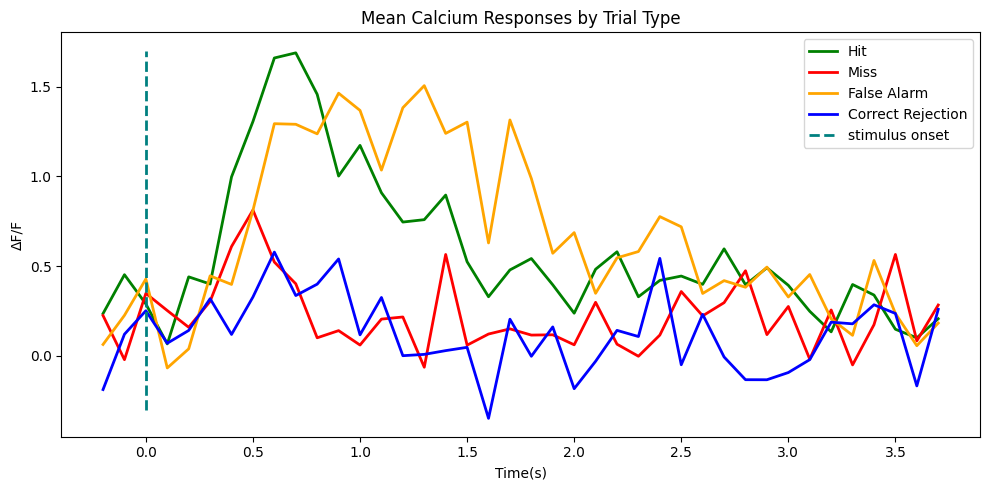

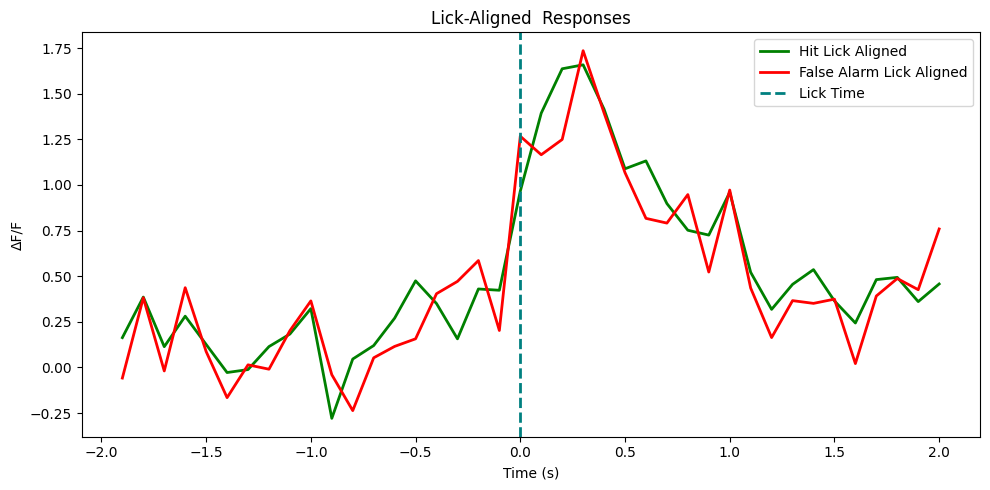

In [14]:
# Step 6: Plot Trial-Type Aligned PSTHs
time1 = np.arange(-baseline, post_stim_period) / 10

plt.figure(figsize=(10, 5))
plt.plot(time1, hit_psth, color='green', label='Hit', linewidth=2)
plt.plot(time1, miss_psth, color='red', label='Miss', linewidth=2)
plt.plot(time1, fa_psth, color="orange", label='False Alarm', linewidth=2)
plt.plot(time1, cr_psth, color="blue", label='Correct Rejection', linewidth=2)
plt.title('Mean Calcium Responses by Trial Type')
plt.xlabel('Time(s)')
plt.ylabel('ΔF/F')
plt.vlines(x=0, ymin=-0.30, ymax=1.70, colors='teal', ls='--', lw=2, label='stimulus onset')
plt.legend()
plt.tight_layout()
plt.show()

# Step 7: Plot Lick-Aligned PSTHs
time2 = np.arange(-((trial_duration // 2 )- 1), trial_duration // 2 + 1) / 10

plt.figure(figsize=(10, 5))
plt.plot(time2, hit_lick_psth, color='green', label='Hit Lick Aligned', linewidth=2)
plt.plot(time2, fa_lick_psth, color="red", label='False Alarm Lick Aligned', linewidth=2)
plt.title('Lick-Aligned  Responses')
plt.axvline(0, color='teal', linestyle='--', linewidth=2, label='Lick Time')
plt.xlabel('Time (s)')
plt.ylabel('ΔF/F')
plt.legend()
plt.tight_layout()
plt.show()

You just learned how to find the average response of the neuron based by trial! 

One neuron isn't enough when you want to analyse a whole dataset, let's learn how to optimise this process. 

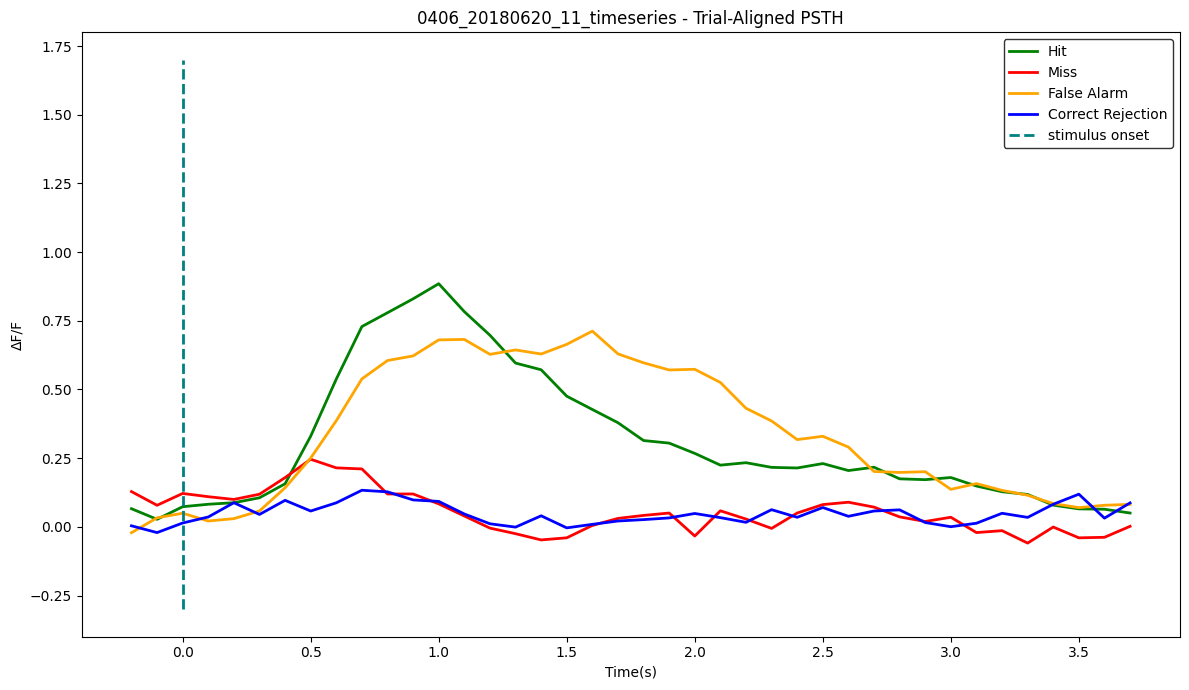

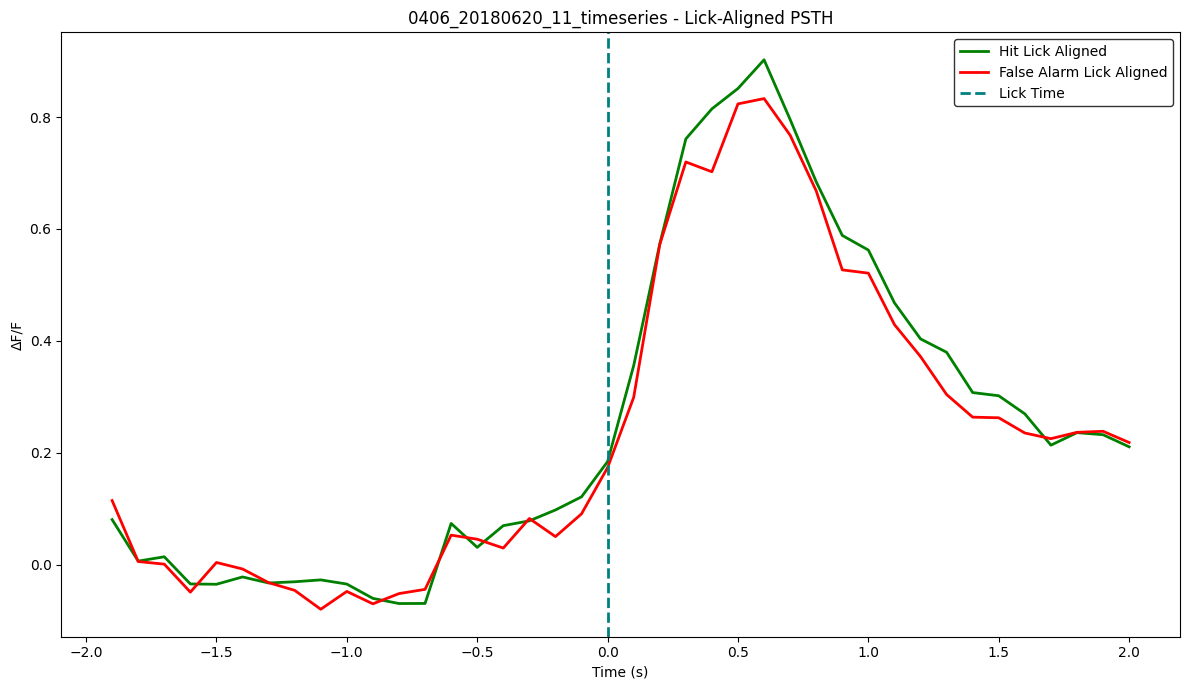

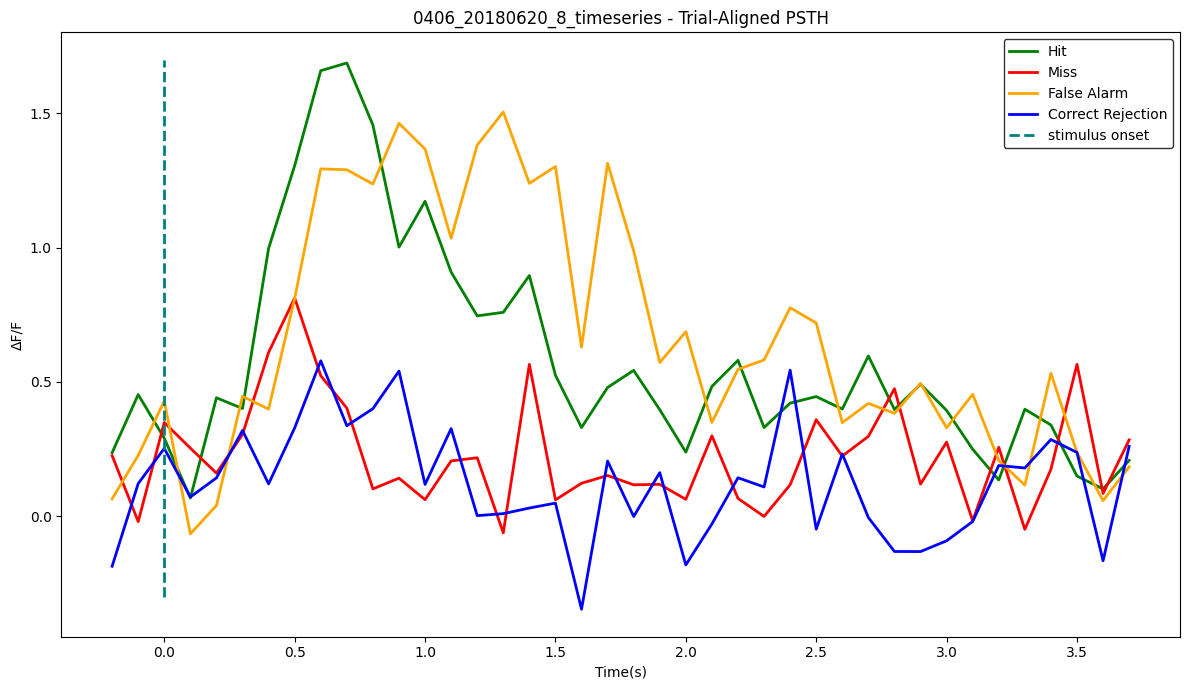

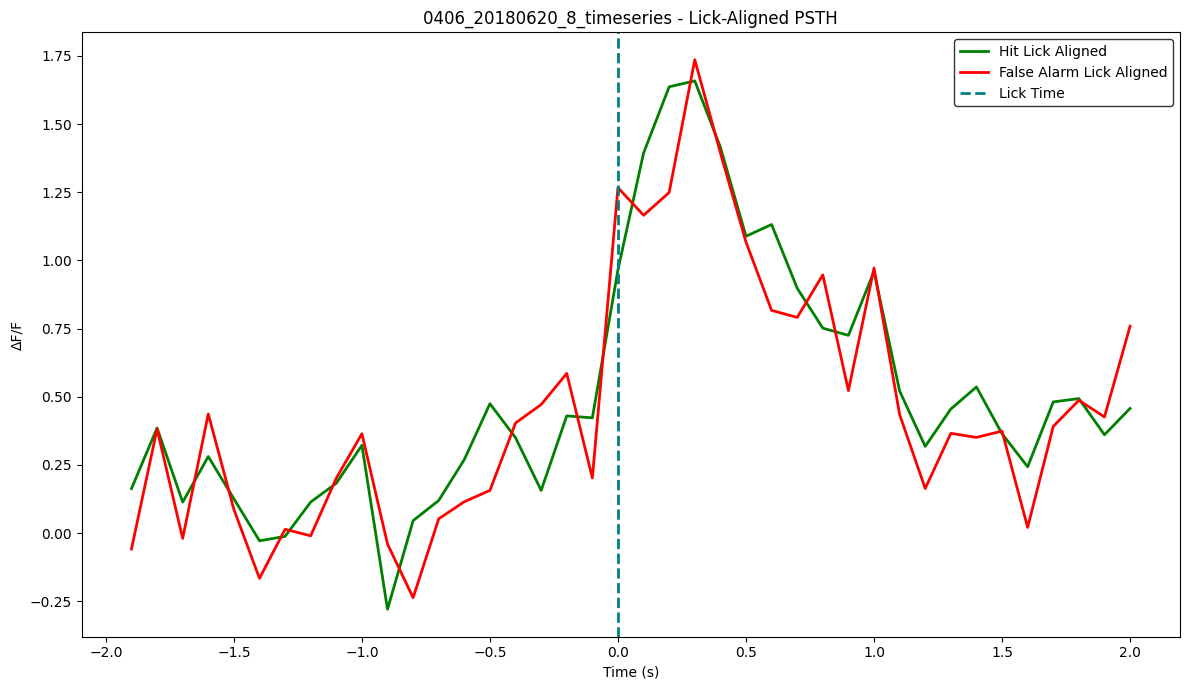

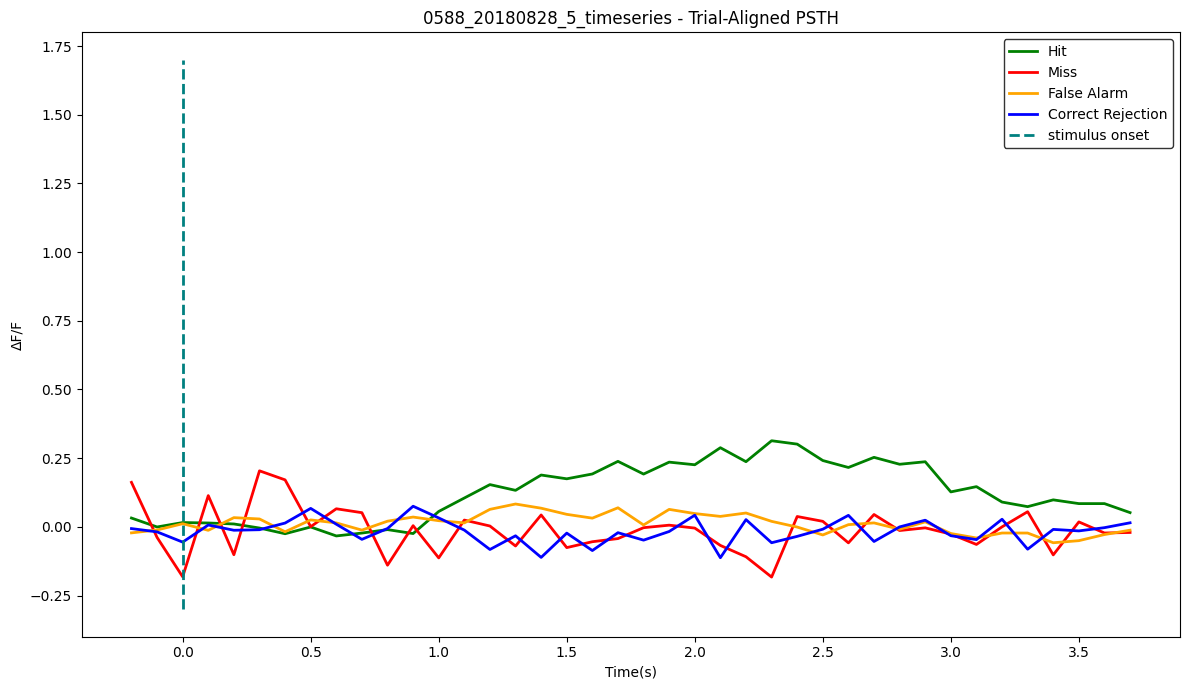

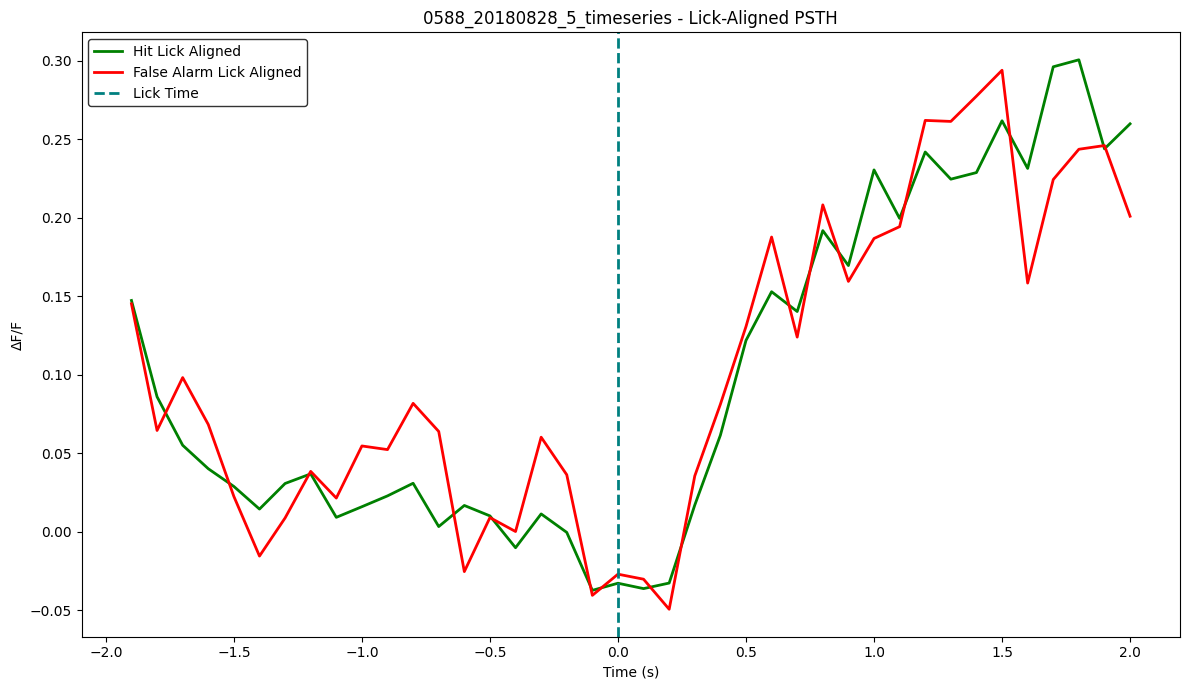

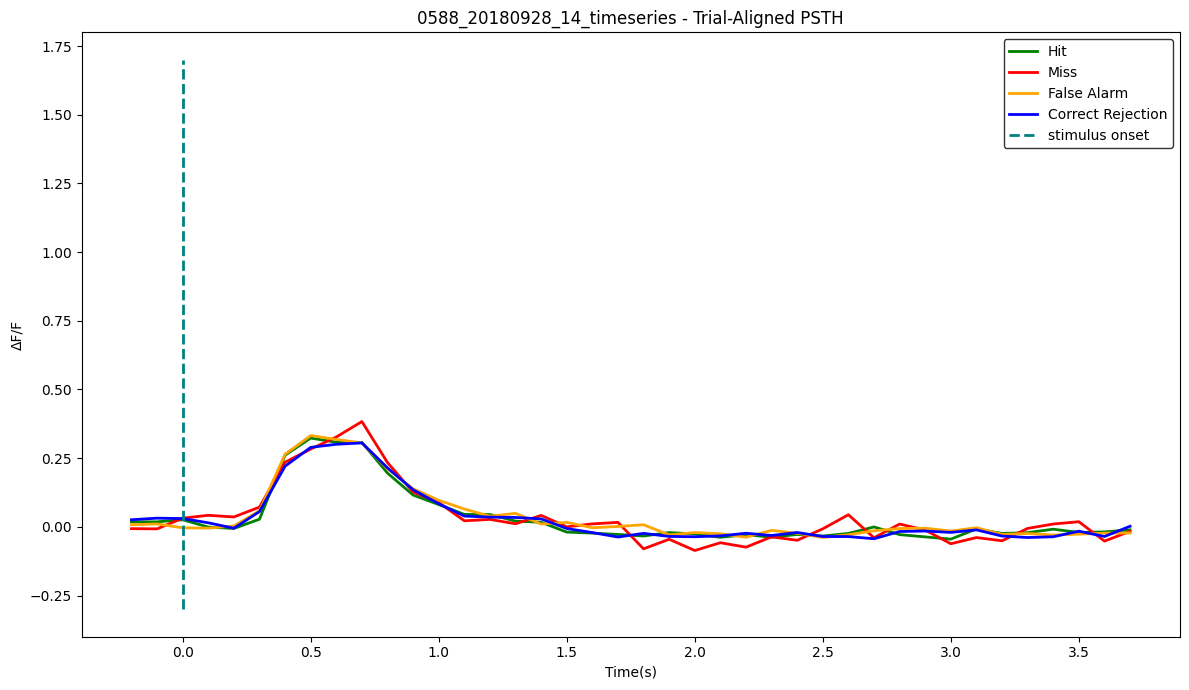

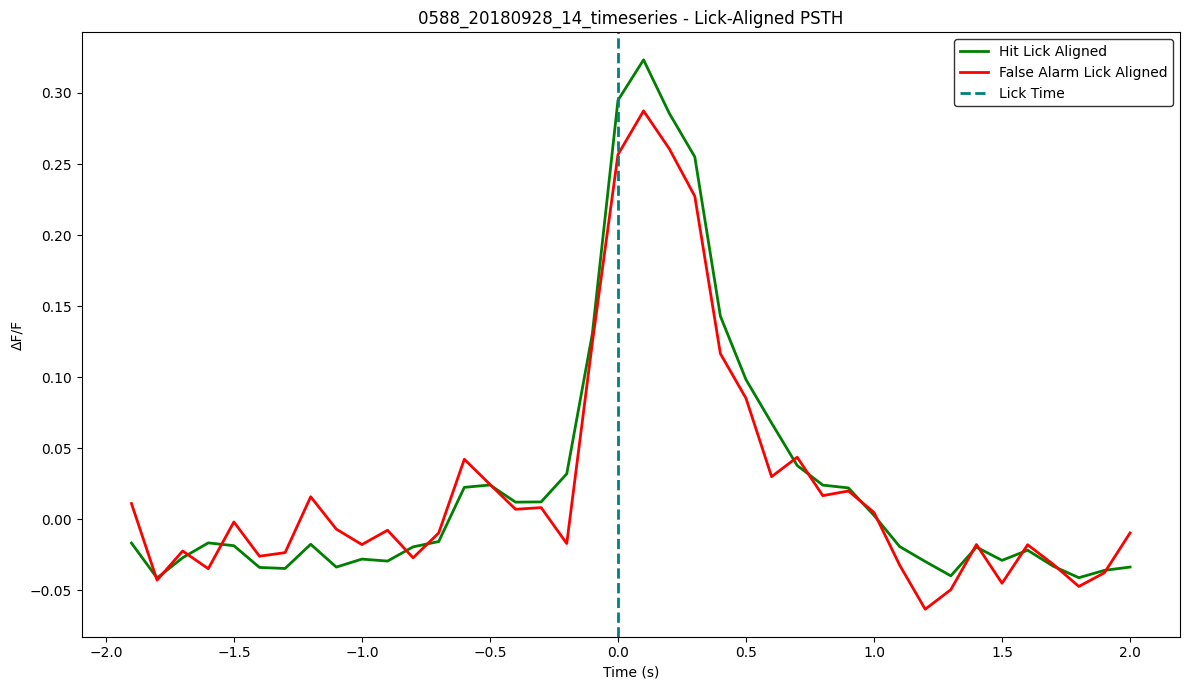

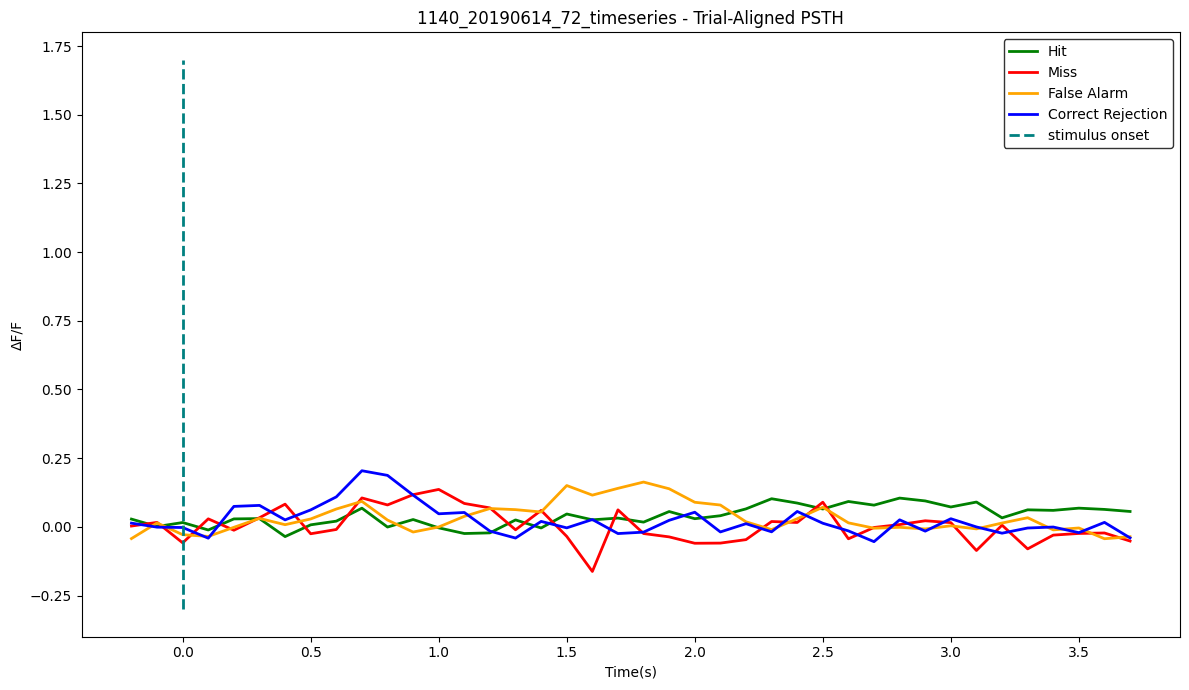

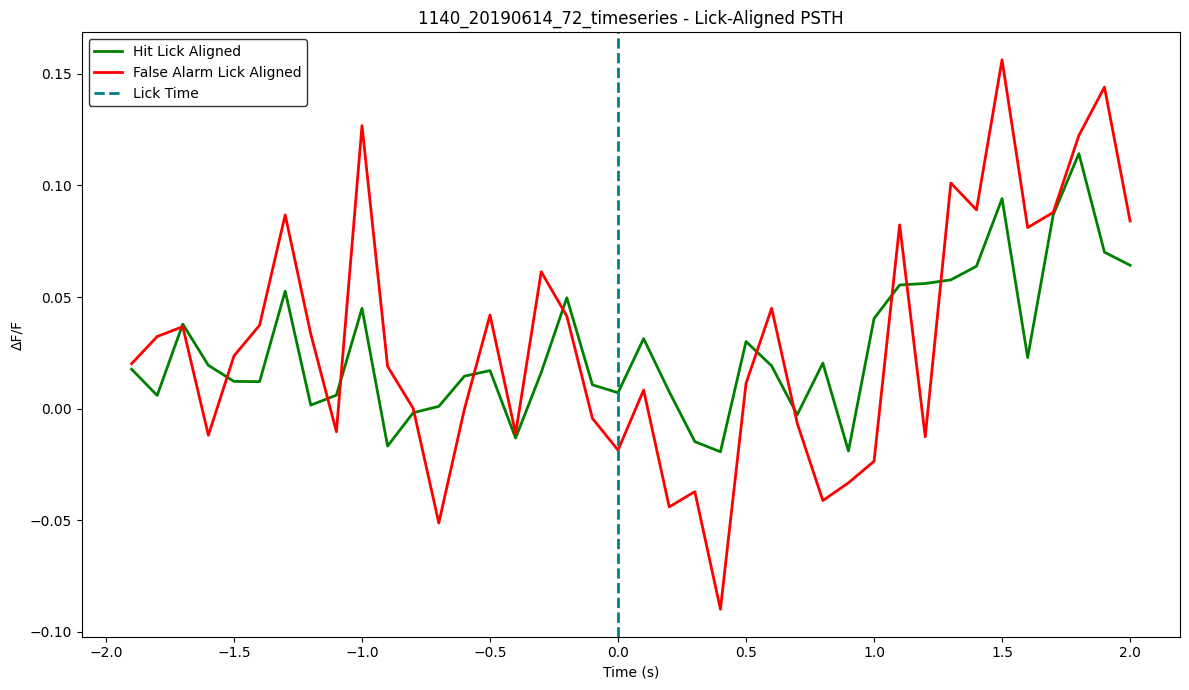

In [ ]:
# the process is quite simple, we are just going to access the folder and repeat this whole code inside a for loop
import os

data_directory = "calcium_traces_data_non_compressed"

for neuron in os.listdir(data_directory):
    #we ignore anything that is not in the right file format
    if not neuron.endswith('.mat'):
        continue

    mat = loadmat(os.path.join(data_directory, neuron))

    # load the variables
    dff = mat['dff'].flatten()
    cues = mat['cues'].flatten()
    reward = mat['reward'].flatten()
    punish =mat['punish'].flatten()
    go= mat['go'].flatten()
    nogo= mat['nogo'].flatten()

    stimtimes = list(np.where(cues ==1)[0])

    # get the number of trials 
    numtrials = len(stimtimes)

    # get the duration of the trial.  The trial duration is the time between one stimulus and the other. 
    #think about it, you have a list of time points where the cues happen. How can you get the amount of time between one cue and the next? 
    trial_duration = stimtimes[1] - stimtimes[0]  # assumes constant duration

    baseline = 2
    post_stim_period = trial_duration - baseline - 1

    # Allocate Containers
    hit_waves = [] 
    miss_waves = []
    fa_waves = []
    cr_waves = []

    # Sort Trials by Type

    #set the counter to all these to 0
    hit = miss = fa = cr = 0

    for itrial in range(numtrials - 1):
        
        istimstart = stimtimes[itrial] # time of the current trial
        next_stim = stimtimes[itrial + 1] # time of the next trial
        start_idx = istimstart - baseline
        end_idx = istimstart + post_stim_period

        #segment of dff
        segment = dff[start_idx:end_idx]

        # checks if the stimulus is Go
        if go[istimstart] == 1:
            # if the stimulus is Go and there is a reward, it means that the mouse licked for the right stimulus! Hurrah!
            if np.any(reward[istimstart:next_stim] ==1 ):
                hit_waves.append(segment)
                hit+=1
            else:
            #if the stimulus is Go and the mouse did not get a reward, it's a miss
                miss_waves.append(segment)
                miss+=1

        # check if the stimulus is NoGo
        elif nogo[istimstart] ==1:
            # if the mouse was punished, it means it licked, therefore false alarm
            if np.any(punish[istimstart:next_stim] ==1 ):
                fa_waves.append(segment)
                fa+=1
            else:
            # otherwise it correctly rejected the NoGo stimulus
                cr_waves.append(segment)
                cr+=1


        # Step 4: Lick-Aligned Waveforms

    # both hit and fa involve the mouse licking (miss and correct rejections means that the mouse doesn't lick)
    hit_lick_waves = []
    fa_lick_waves = []

    #same thing as before 
    for itrial in range(1, numtrials - 1):
        istimstart = stimtimes[itrial]
        next_stim = stimtimes[itrial + 1]
        
    # here it's a bit different, but we basically get whether the mouse was rewarded (aka licked correctly)
        if go[istimstart] == 1:
            licktimes = np.where(reward[istimstart:next_stim] > 0)[0] # the reward is given if the mouse licks correctly 
            if len(licktimes) > 0:
                lick_index = istimstart + licktimes[0]
                start = lick_index - trial_duration // 2
                end = lick_index + trial_duration // 2
                segment = dff[start:end]
                #print(lick_index, licktimes, licktimes[0])

                hit_lick_waves.append(segment)
        #or we get whether the mouse was punished (licked but shouldn't have)
        elif nogo[istimstart] > 0:
            licktimes = np.where(punish[istimstart:next_stim] > 0)[0]
            if len(licktimes) > 0:
                start = lick_index - trial_duration // 2
                end = lick_index + trial_duration // 2
                segment = dff[start:end]
                fa_lick_waves.append(segment)



    hit_lick_waves = np.array(hit_lick_waves).T if hit_lick_waves else np.empty((trial_duration, 0))
    fa_lick_waves = np.array(fa_lick_waves).T if fa_lick_waves else np.empty((trial_duration, 0))



    # Compute PSTHs
    hit_psth = np.mean(hit_waves, axis=0) 
    miss_psth = np.mean(miss_waves, axis=0) 
    fa_psth = np.mean(fa_waves, axis=0) 
    cr_psth = np.mean(cr_waves, axis=0)
    hit_lick_psth = np.mean(hit_lick_waves, axis=1)
    fa_lick_psth = np.mean(fa_lick_waves, axis=1)

    #Plotting -- same thing as before, but we are going to plot the name of the neurons
    base_name = neuron.replace('.mat', '')

    #we are also going to save our plots in a subdirectory
    plot_dir = os.path.join(data_directory, 'plots')  # folder to save plots
    os.makedirs(plot_dir, exist_ok=True)


    # Plot Trial-Type Aligned PSTHs
    # for plot 1 add 
    # plt.title(f'{base_name} - Trial-Aligned PSTH')

    time1 = np.arange(-baseline, post_stim_period) / 10

    #this is just a little bit of code that makes the plots look nicer when we save them

    plt.rcParams.update({
    "axes.facecolor": "white",
    "figure.facecolor": "white",
    "savefig.facecolor": "white",
    "axes.edgecolor": "black",
    "xtick.color": "black",
    "ytick.color": "black",
    "axes.labelcolor": "black",
    "text.color": "black",
    "legend.edgecolor": "black",
    })


    plt.figure(figsize=(12, 7))
    plt.plot(time1, hit_psth, color='green', label='Hit', linewidth=2)
    plt.plot(time1, miss_psth, color='red', label='Miss', linewidth=2)
    plt.plot(time1, fa_psth, color="orange", label='False Alarm', linewidth=2)
    plt.plot(time1, cr_psth, color="blue", label='Correct Rejection', linewidth=2)
    plt.title(f'{base_name} - Trial-Aligned PSTH')
    plt.xlabel('Time(s)')
    plt.ylabel('ΔF/F')
    plt.vlines(x=0, ymin=-0.30, ymax=1.70, colors='teal', ls='--', lw=2, label='stimulus onset')
    plt.legend()
    plt.tight_layout()
    plt.gcf().canvas.draw() 
    plt.savefig(os.path.join(plot_dir, f'{base_name}_trial_aligned.png'))
    plt.show()
    plt.close()


    # for plot 2 add plt.title(f'{base_name} - Lick-Aligned PSTH')
    time2 = np.arange(-((trial_duration // 2 )- 1), trial_duration // 2 + 1) / 10

    plt.figure(figsize=(12, 7))
    plt.plot(time2, hit_lick_psth, color='green', label='Hit Lick Aligned', linewidth=2)
    plt.plot(time2, fa_lick_psth, color="red", label='False Alarm Lick Aligned', linewidth=2)
    plt.title(f'{base_name} - Lick-Aligned PSTH')
    plt.axvline(0, color='teal', linestyle='--', linewidth=2, label='Lick Time')
    plt.xlabel('Time (s)')
    plt.ylabel('ΔF/F')
    plt.legend()
    plt.tight_layout()
    plt.gcf().canvas.draw() 
    plt.savefig(os.path.join(plot_dir, f'{base_name}_lick_aligned.png'))
    plt.show()
    plt.close()


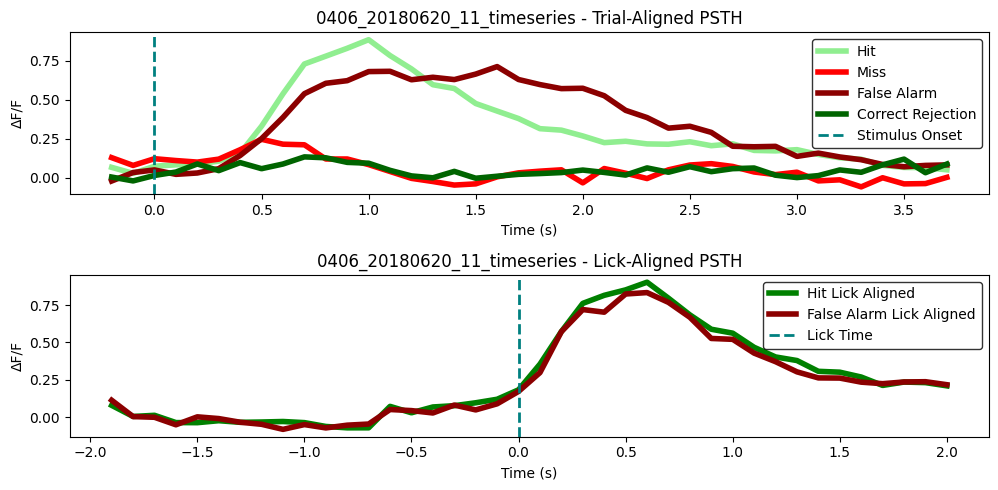

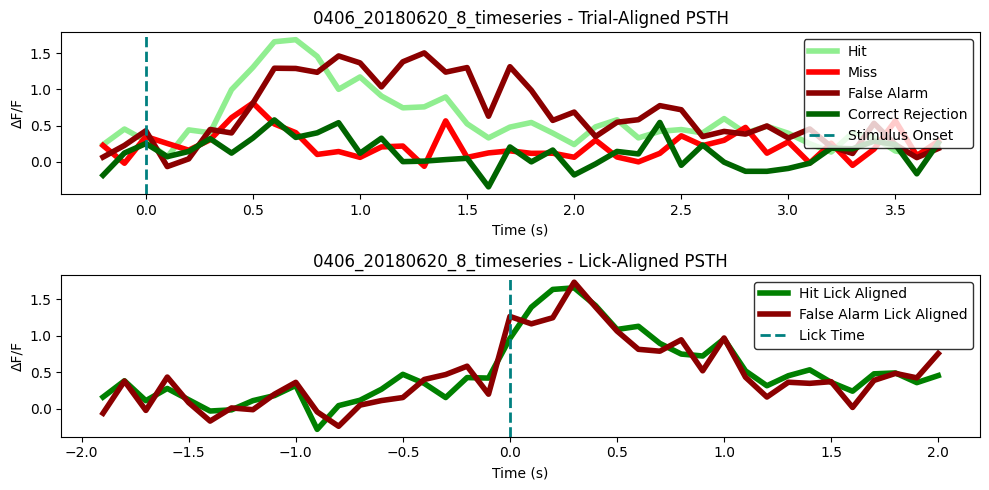

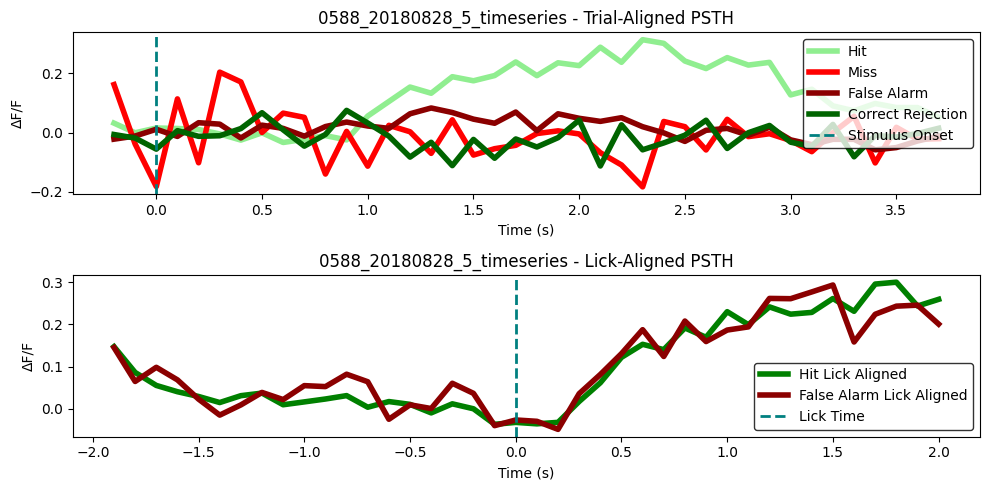

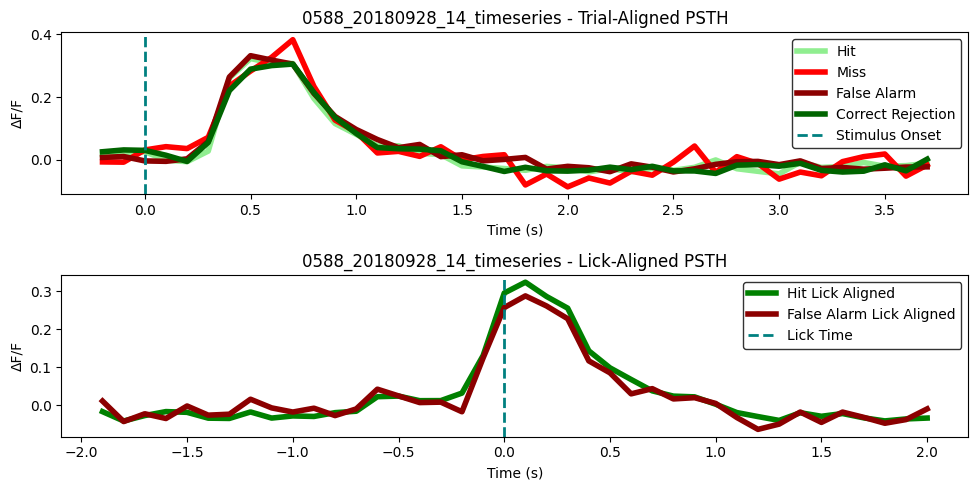

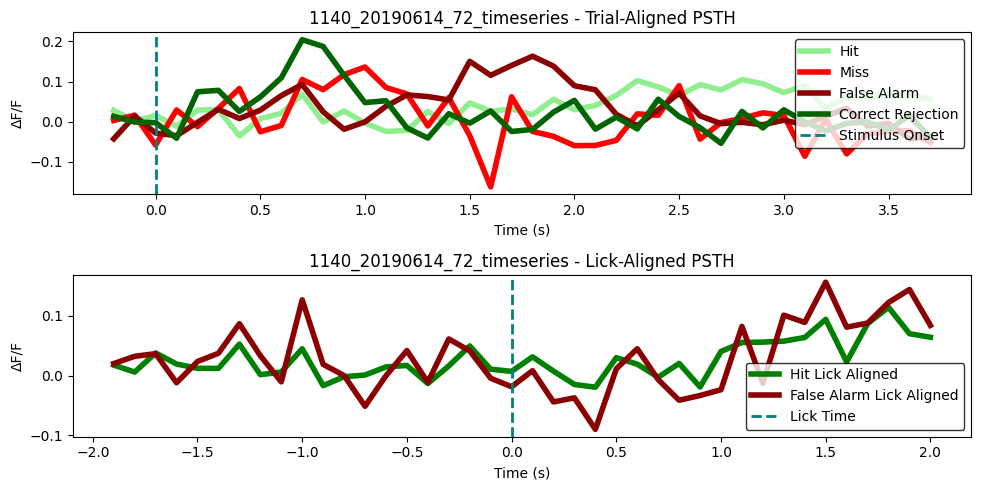

In [20]:
# the process is quite simple, we are just going to access the folder and repeat this whole code inside a for loop
import os

data_directory = "calcium_traces_data_non_compressed"

for neuron in os.listdir(data_directory):
    #we ignore anything that is not in the right file format
    if not neuron.endswith('.mat'):
        continue

    mat = loadmat(os.path.join(data_directory, neuron))

    # load the variables
    dff = mat['dff'].flatten()
    cues = mat['cues'].flatten()
    reward = mat['reward'].flatten()
    punish =mat['punish'].flatten()
    go= mat['go'].flatten()
    nogo= mat['nogo'].flatten()

    stimtimes = list(np.where(cues ==1)[0])

    # get the number of trials 
    numtrials = len(stimtimes)

    # get the duration of the trial.  The trial duration is the time between one stimulus and the other. 
    #think about it, you have a list of time points where the cues happen. How can you get the amount of time between one cue and the next? 
    trial_duration = stimtimes[1] - stimtimes[0]  # assumes constant duration

    baseline = 2
    post_stim_period = trial_duration - baseline - 1

    # Allocate Containers
    hit_waves = [] 
    miss_waves = []
    fa_waves = []
    cr_waves = []

    # Sort Trials by Type

    #set the counter to all these to 0
    hit = miss = fa = cr = 0

    for itrial in range(numtrials - 1):
        
        istimstart = stimtimes[itrial] # time of the current trial
        next_stim = stimtimes[itrial + 1] # time of the next trial
        start_idx = istimstart - baseline
        end_idx = istimstart + post_stim_period

        #segment of dff
        segment = dff[start_idx:end_idx]

        # checks if the stimulus is Go
        if go[istimstart] == 1:
            # if the stimulus is Go and there is a reward, it means that the mouse licked for the right stimulus! Hurrah!
            if np.any(reward[istimstart:next_stim] ==1 ):
                hit_waves.append(segment)
                hit+=1
            else:
            #if the stimulus is Go and the mouse did not get a reward, it's a miss
                miss_waves.append(segment)
                miss+=1

        # check if the stimulus is NoGo
        elif nogo[istimstart] ==1:
            # if the mouse was punished, it means it licked, therefore false alarm
            if np.any(punish[istimstart:next_stim] ==1 ):
                fa_waves.append(segment)
                fa+=1
            else:
            # otherwise it correctly rejected the NoGo stimulus
                cr_waves.append(segment)
                cr+=1


        # Step 4: Lick-Aligned Waveforms

    # both hit and fa involve the mouse licking (miss and correct rejections means that the mouse doesn't lick)
    hit_lick_waves = []
    fa_lick_waves = []

    #same thing as before 
    for itrial in range(1, numtrials - 1):
        istimstart = stimtimes[itrial]
        next_stim = stimtimes[itrial + 1]
        
    # here it's a bit different, but we basically get whether the mouse was rewarded (aka licked correctly)
        if go[istimstart] == 1:
            licktimes = np.where(reward[istimstart:next_stim] > 0)[0] # the reward is given if the mouse licks correctly 
            if len(licktimes) > 0:
                lick_index = istimstart + licktimes[0]
                start = lick_index - trial_duration // 2
                end = lick_index + trial_duration // 2
                segment = dff[start:end]
                #print(lick_index, licktimes, licktimes[0])

                hit_lick_waves.append(segment)
        #or we get whether the mouse was punished (licked but shouldn't have)
        elif nogo[istimstart] > 0:
            licktimes = np.where(punish[istimstart:next_stim] > 0)[0]
            if len(licktimes) > 0:
                start = lick_index - trial_duration // 2
                end = lick_index + trial_duration // 2
                segment = dff[start:end]
                fa_lick_waves.append(segment)



    hit_lick_waves = np.array(hit_lick_waves).T if hit_lick_waves else np.empty((trial_duration, 0))
    fa_lick_waves = np.array(fa_lick_waves).T if fa_lick_waves else np.empty((trial_duration, 0))



    # Compute PSTHs
    hit_psth = np.mean(hit_waves, axis=0) 
    miss_psth = np.mean(miss_waves, axis=0) 
    fa_psth = np.mean(fa_waves, axis=0) 
    cr_psth = np.mean(cr_waves, axis=0)
    hit_lick_psth = np.mean(hit_lick_waves, axis=1)
    fa_lick_psth = np.mean(fa_lick_waves, axis=1)

    #Plotting -- same thing as before, but we are going to plot the name of the neurons
    base_name = neuron.replace('.mat', '')

    #we are also going to save our plots in a subdirectory
    plot_dir = os.path.join(data_directory, 'plots')  # folder to save plots
    os.makedirs(plot_dir, exist_ok=True)


    # Plot Trial-Type Aligned PSTHs
    # for plot 1 add 
    # plt.title(f'{base_name} - Trial-Aligned PSTH')

        # Plot Trial-Type Aligned PSTHs
    # for plot 1 add 
    # plt.title(f'{base_name} - Trial-Aligned PSTH')

    time1 = np.arange(-baseline, post_stim_period) / 10

    plt.rcParams.update({
    "axes.facecolor": "white",
    "figure.facecolor": "white",
    "savefig.facecolor": "white",
    "axes.edgecolor": "black",
    "xtick.color": "black",
    "ytick.color": "black",
    "axes.labelcolor": "black",
    "text.color": "black",
    "legend.edgecolor": "black",
    })

    # Create figure and subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 5))

    # Plot 1 – Trial-Aligned PSTH
    ax1.plot(time1, hit_psth, color='lightgreen', label='Hit',linewidth=4)  
    ax1.plot(time1, miss_psth, color='red', linewidth=4, label='Miss')
    ax1.plot(time1, fa_psth, color="darkred", linewidth=4, label='False Alarm')
    ax1.plot(time1, cr_psth, color="darkgreen", linewidth=4, label='Correct Rejection')
    ax1.axvline(x=0, color='teal', linestyle='--', linewidth=2, label='Stimulus Onset')
    ax1.set_title(f'{base_name} - Trial-Aligned PSTH')
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('ΔF/F')
    ax1.legend()

    # Plot 2 – Lick-Aligned PSTH
    ax2.plot(time2, hit_lick_psth, color='green', linewidth=4,label='Hit Lick Aligned')
    ax2.plot(time2, fa_lick_psth, color="darkred",linewidth=4, label='False Alarm Lick Aligned')
    ax2.axvline(x=0, color='teal', linestyle='--', linewidth=2, label='Lick Time')
    ax2.set_title(f'{base_name} - Lick-Aligned PSTH')
    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel('ΔF/F')
    ax2.legend()

    # Finalize and save
    plt.tight_layout()
    plt.gcf().canvas.draw()
    #plt.savefig(os.path.join(plot_dir, f'{base_name}_combined_psth.png'))
    plt.show()
    plt.close()
